<a href="https://colab.research.google.com/github/mayanlong2020/ColabDesign/blob/main/af/design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AfDesign (v1.1.1)
Backprop through AlphaFold for protein design.

**WARNING**
1.   This notebook is in active development and was designed for demonstration purposes only.
2.   Using AfDesign as the only "loss" function for design might be a bad idea, you may find adversarial sequences (aka. sequences that trick AlphaFold).

In [2]:
#@title setup
%%time
import os
if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

CPU times: user 56 µs, sys: 4 µs, total: 60 µs
Wall time: 55.8 µs


# fixed backbone design (fixbb)
For a given protein backbone, generate/design a new sequence that AlphaFold thinks folds into that conformation.

In [4]:
clear_mem()
af_model = mk_afdesign_model(protocol="fixbb")
af_model.prep_inputs(pdb_filename=get_pdb("1TEN"), chain="A")

print("length",  af_model._len)
print("weights", af_model.opt["weights"])

length 89
weights {'con': 0.0, 'dgram_cce': 1.0, 'exp_res': 0.0, 'fape': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'rmsd': 0.0, 'seq_ent': 0.0}


In [5]:
af_model.restart()
af_model.design_3stage()

Stage 1: running (logits → soft)
1 models [4] recycles 0 hard 0 soft 0.00 temp 1 seqid 0.02 loss 5.90 dgram_cce 5.90 plddt 0.63 ptm 0.14 rmsd 57.74
2 models [4] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.04 loss 5.48 dgram_cce 5.48 plddt 0.64 ptm 0.14 rmsd 30.87
3 models [4] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.03 loss 5.27 dgram_cce 5.27 plddt 0.73 ptm 0.26 rmsd 32.41
4 models [2] recycles 0 hard 0 soft 0.01 temp 1 seqid 0.03 loss 4.39 dgram_cce 4.39 plddt 0.53 ptm 0.13 rmsd 30.33
5 models [1] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.07 loss 3.93 dgram_cce 3.93 plddt 0.48 ptm 0.14 rmsd 27.55
6 models [3] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.06 loss 3.56 dgram_cce 3.56 plddt 0.35 ptm 0.15 rmsd 17.52
7 models [1] recycles 0 hard 0 soft 0.02 temp 1 seqid 0.06 loss 3.46 dgram_cce 3.46 plddt 0.37 ptm 0.16 rmsd 19.94
8 models [4] recycles 0 hard 0 soft 0.03 temp 1 seqid 0.06 loss 3.91 dgram_cce 3.91 plddt 0.52 ptm 0.12 rmsd 25.57
9 models [3] recycles 0 hard 0 soft 0.03 temp 1

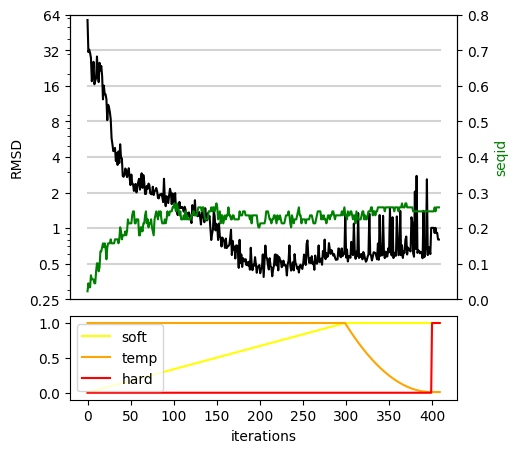

In [6]:
af_model.plot_traj()

In [7]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
HTML(af_model.animate())

In [10]:
af_model.get_seqs()

['AEPCTGMTVSGVTDNQATISWEPAKTPADYVLVQIGRWGDPTDRHWYALPASTNSMHFTGLEPGVQYWVMITTYNGGNFAEPQTMWFST']

# hallucination
For a given length, generate/hallucinate a protein sequence that AlphaFold thinks folds into a well structured protein (high plddt, low pae, many contacts).

In [ ]:
clear_mem()
af_model = mk_afdesign_model(protocol="hallucination")
af_model.prep_inputs(length=100)

print("length",af_model._len)
print("weights",af_model.opt["weights"])

In [ ]:
# pre-design with gumbel initialization and softmax activation
af_model.restart(mode="gumbel")
af_model.design_soft(50)

# three stage design
af_model.set_seq(af_model.aux["seq"]["pseudo"])
af_model.design_3stage(50,50,10)

In [ ]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb()

In [ ]:
HTML(af_model.animate())

In [ ]:
af_model.get_seqs()

# binder hallucination
For a given protein target and protein binder length, generate/hallucinate a protein binder sequence AlphaFold thinks will bind to the target structure.
To do this, we minimize PAE and maximize number of contacts at the interface and within the binder, and we maximize pLDDT of the binder.
By default, AlphaFold-ptm with residue index offset hack is used. To enable AlphaFold-multimer set: mk_afdesign_model(use_multimer=True).


In [ ]:
clear_mem()
af_model = mk_afdesign_model(protocol="binder")
af_model.prep_inputs(pdb_filename=get_pdb("4MZK"), chain="A", binder_len=19)

print("target_length",af_model._target_len)
print("binder_length",af_model._binder_len)
print("weights",af_model.opt["weights"])

In [ ]:
af_model.restart()
af_model.design_3stage(100,100,10)

In [ ]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb()

In [ ]:
HTML(af_model.animate())

In [ ]:
af_model.get_seqs()

#**ADVANCED**

## partial hallucination + custom Radius of Gyration (rg) loss
mix supervised (fixbb) and unsupervised (hallucination) losses to constrain the halluciation process.

In [ ]:
import jax
import jax.numpy as jnp
from colabdesign.af.alphafold.common import residue_constants

# first off, let's implement a custom Radius of Gyration loss function
def rg_loss(inputs, outputs):
  positions = outputs["structure_module"]["final_atom_positions"]
  ca = positions[:,residue_constants.atom_order["CA"]]
  center = ca.mean(0)
  rg = jnp.sqrt(jnp.square(ca - center).sum(-1).mean() + 1e-8)
  rg_th = 2.38 * ca.shape[0] ** 0.365
  rg = jax.nn.elu(rg - rg_th)
  return {"rg":rg}

In [ ]:
clear_mem()
af_model = mk_afdesign_model(protocol="partial",
                             loss_callback=rg_loss, # add rg_loss
                             use_templates=False)   # set True to constrain positions using template input

af_model.opt["weights"]["rg"] = 0.1  # optional: specify weight for rg_loss

af_model.prep_inputs(pdb_filename=get_pdb("6MRR"),
                     chain="A",
                     pos="3-30,33-68",  # define positions to contrain
                     length=100)          # total length if different from input pdb

af_model.rewire(loops=[36]) # set loop length between segments

In [ ]:
# initialize with wildtype seq, fill in the rest with soft_gumbel distribution
af_model.restart(mode=["soft","gumbel","wildtype"])
af_model.design_3stage(100, 100, 10)

In [ ]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb()

In [ ]:
HTML(af_model.animate())

In [ ]:
af_model.get_seqs()